# Classify sentiments in text using Tensorflow

Here I'm using [News Headlines Dataset For Sarcasm Detection ](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection)
by [Rishabh Misra](https://www.kaggle.com/rmisra) to create a deep learning model which will be able to classify a sentence
as `sarcastic or not`.

**While doing all of this we will go through:**
- How to `preprocess text` for neural networks
- Importance of `Word Embedding` and how to visualize them
- When to use `GlobalAveragePooling1D` and `Flatten`

In [1]:
import io
import re
import json
import unicodedata

import numpy as np
import pandas as pd
from seaborn import countplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Flatten, Dense

tf.__version__

'2.3.0'

In [2]:
!pip install contractions

     |████████████████████████████████| 260 kB 816 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


## 🛳 Getting dataset

The `json` file here is `invalid` and cannot be printed directly. The reason is because here the JSON has multiple objects at the top level. The solution is wrap those multiple objects in to one top level array and then make those objects its elements. Refer to this 👉 [stackoverflow post](https://stackoverflow.com/questions/51919698/cant-parse-json-file-json-decoder-jsondecodeerror-extra-data) for more details.

In [4]:
# Print few examples from the json file
def print_invalid_json(filename, num_of_examples=5):
    with open(filename) as f:
        data = json.loads('[' + f.read().replace('}\n{', '}, \n{') + ']')
    print(json.dumps(data[:num_of_examples], indent=2, sort_keys=True))

In [5]:
# Getting the dataset
def load_dataset():
    # There are 2 json files in which the data is stored
    first_file_path = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
    second_file_path = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'

    # Printing json file examples
    print(f'2 examples from first json file\n')
    print_invalid_json(first_file_path, num_of_examples=2)
    print(f'\n\n2 examples from second json file\n')
    print_invalid_json(second_file_path, num_of_examples=2)

    first_df = pd.read_json(first_file_path, lines=True)
    second_df = pd.read_json(second_file_path, lines=True)
    return pd.concat([first_df, second_df], axis='rows')


df = load_dataset()
df.sample(5)

2 examples from first json file

[
  {
    "article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5",
    "headline": "former versace store clerk sues over secret 'black code' for minority shoppers",
    "is_sarcastic": 0
  },
  {
    "article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365",
    "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
    "is_sarcastic": 0
  }
]


2 examples from second json file

[
  {
    "article_link": "https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205",
    "headline": "thirtysomething scientists unveil doomsday clock of hair loss",
    "is_sarcastic": 1
  },
  {
    "article_link": "https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207",
    "headline": "dem rep. totally nails why congress is falling short on gender, racial equality",


,article_link,headline,is_sarcastic
236,https://www.huffingtonpost.com/entry/google-ti...,discover how climate change is rapidly transfo...,0
13309,https://entertainment.theonion.com/jeff-bridge...,jeff bridges seated directly behind support co...,1
22411,https://www.huffingtonpost.comhttp://highline....,this is what it feels like to lose to donald t...,0
15127,https://www.huffingtonpost.com/entry/parent-fu...,why we should remember to treat every day like...,0
13556,https://www.theonion.com/new-biblical-text-rev...,new biblical text reveals god first sent chris...,1


## 🚧 Data preparation

![](https://media.giphy.com/media/xsATxBQfeKHCg/giphy.gif)

Let's see how much the dataset is `balanced`.

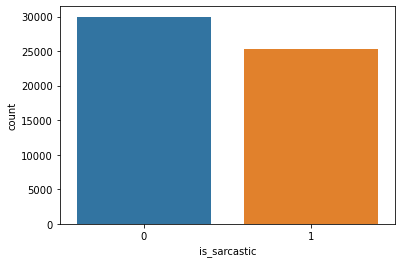

In [6]:
countplot(df.is_sarcastic)

Dropping the `article_link` column as I'm just going to use `headline` text as data. You can use the links, make `GET` request and `parse` the content to get more data. Here one concern will be that you have to use more complex model if your sentence or paragraphs are too long.

In [7]:
df.drop(['article_link'], axis='columns', inplace=True)
df.sample(5)

,headline,is_sarcastic
16307,huffpollster: texas and massachusetts are the ...,0
21555,diego luna's short film celebrates 'the immigr...,0
6100,14-year anniversary of 'crash bandicoot' passe...,1
12224,"sleeping man flanked by laptop, phone, earbuds...",1
5935,justin bieber's latest 'carpool karaoke' is to...,0


In [8]:
def expand_contractions(text, contraction_map=contractions_dict):    
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)     
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [9]:
# lowering the case of text and keys and values of contraction_dict to avoid any discrepancies

df.headline = df.headline.apply(str.lower)
print(df.sample(5))

print()

contractions_dict = {key.lower(): value.lower() for key, value in contractions_dict.items()}
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

                                                headline  is_sarcastic
14376  nation's economists quietly evacuating their f...             1
19181                    mars and venus in mental health             0
6987   queen elizabeth ii to wed longtime partner fol...             1
5353   perfect response to heckler somewhere in prop ...             1
11086  regal cinemas suddenly realizes it's been play...             1

i'm == i am
i'm'a == i am about to
i'm'o == i am going to
i've == i have
i'll == i will
i'll've == i will have
i'd == i would
i'd've == i would have
whatcha == what are you
amn't == am not


Removing all `months` shorthands `(mar.|dec.|oct.)` as it confuses our `regex pattern`. For examples: `mark`, `deci`, `deca`, etc. This happens due to the `dot(.)` char at the end which match any one char. There might be other such chars that will produce such issues. To fix this just replace `.` with this `\.` which will ensure that only if there is `.` char then only make changes.

In [10]:
def refactor_contraction_dict(contraction_map):
    new_contraction_dict = {}
    for key, value in contraction_map.items():
        if '.' in key:
            key = key.replace('.', '\.')
        new_contraction_dict[key] = value
    return new_contraction_dict


contractions_dict = refactor_contraction_dict(contractions_dict)
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

i'm == i am
i'm'a == i am about to
i'm'o == i am going to
i've == i have
i'll == i will
i'll've == i will have
i'd == i would
i'd've == i would have
whatcha == what are you
amn't == am not


In [11]:
df.headline = df.headline.apply(lambda x: expand_contractions(x))
df.sample(5)

,headline,is_sarcastic
24875,anti-abortion governor ironically tweets about...,0
28380,obamacare repeal could be more difficult than ...,0
22114,tsa agents to now simply stand at checkpoints ...,1
8716,determined circle of friends diligently traces...,1
17766,the american stories that cannot be untold,0


In [12]:
# Removing unnecessary characters from text
def clean_text(text):
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()
    
    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

In [13]:
df.headline = df.headline.apply(lambda x: clean_text(x))
df.sample(5)

,headline,is_sarcastic
7115,report it apparently time in conversation to s...,1
21971,new grill to revive fortheman-ali rivalry,1
8775,furloughed bison pour back into national parks...,1
19610,hey all you 20-somethings breathe,0
22990,the 10 most crushworthy leading women in ya,0


### Preparaing dataset for neural networks

In [14]:
# Suffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Splitting the dataset into training & testing
x_train, x_test, y_train, y_test = train_test_split(
    df[['headline']], df[['is_sarcastic']], 
    test_size=0.15, 
    random_state=0
)

In [15]:
sentences = x_train.headline.tolist()
y = y_train.is_sarcastic.tolist()

sentences[:5]

['entire room mentally shaving mans facial hair',
 'obesity-study lab rats life pretty sweet',
 'iraq pm ythemen conflict could engulf entire region in war',
 'satellite images indicate north korea is working on ballistic missile subne',
 'aretha franklin dthemands f-u-d-g-e']

Setting a `vocabulary` size and `token` for words which are not in our vocabulary (`<UNK>` or `<OOV>`).

In [16]:
print(f"Vocab size: {len(set(' '.join(sentences).split(' ')))}")

vocab_size = 15_000
oov_token = '<OOV>'

Vocab size: 29332


`Tokenizing` sentences as `neural networks` work with `numeric` data.

In [17]:
# Example
def tokenizing_example():
    sentences = [
        'You are really amazing',
        'You are really beautiful',
        'Let\'s build AI for global domination!!!'
    ]
    
    tokenizer = Tokenizer(num_words=6, oov_token='<OOV>')
    tokenizer.fit_on_texts(sentences)

    word_index = tokenizer.word_index
    print(f'Word index (vocab): \n{json.dumps(word_index, indent=2, sort_keys=True)}\n')
    print(tokenizer.texts_to_sequences(sentences))
    
    
tokenizing_example()

Word index (vocab): 
{
  "<OOV>": 1,
  "ai": 9,
  "amazing": 5,
  "are": 3,
  "beautiful": 6,
  "build": 8,
  "domination": 12,
  "for": 10,
  "global": 11,
  "let's": 7,
  "really": 4,
  "you": 2
}

[[2, 3, 4, 5], [2, 3, 4, 1], [1, 1, 1, 1, 1, 1]]


No word in 3rd sentence is available in our vocabulary and that's why they are assigned `<OOV>` i.e. `out of vocabulary`.

`Tensorflow`'s `Tokenizer` object is very sophisticated as here you don't need to worry about filtering text (or word) and many methods such `word_index` and so on which will make your life easy.

In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

**Setting max length for our sentences**

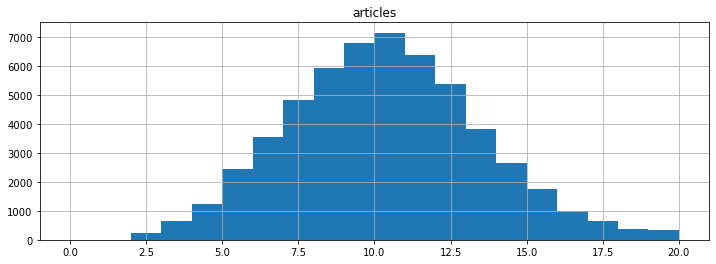

In [19]:
headline_word_count = [len(sentence.split()) for sentence in df.headline]
headline_word_count[:10]

# Analyze the distribution of sequences by looking at the length of the texts
pd.DataFrame({'articles': headline_word_count}).hist(
    bins=20, figsize=(12, 4), range=[0, 20]
)
plt.show()

So majority of the `headlines` has `8 to 11` words in them.

In [20]:
max_length = 11
padding_type = 'post'
truncating_type = 'post'

As different sentences are of different length, so to make them of a specific length we can do two things `padding` or `truncating` and for these work we can use `Tensorflow`'s `pad_sequences` object.

In [21]:
# Example
def padding_example():
    sentences = [
        'You are really amazing',
        'You are really beautiful',
        'Let\'s build AI for global domination!!!'
    ]
    
    tokenizer = Tokenizer(num_words=6, oov_token='<OOV>')
    tokenizer.fit_on_texts(sentences)
    
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, maxlen=6, padding='post', truncating='post')
    print(padded)
    
    
padding_example()

[[2 3 4 5 0 0]
 [2 3 4 1 0 0]
 [1 1 1 1 1 1]]


Here `padding` and `truncating` have two options `pre`(starting) and `post`(end) which specifices from where to do their tasks repectively. Since first two sentences are small so they are padded to `maxlen` i.e. 6 and the number `0` represents that.

**Note**: You can also pass `sequences` of various lengths to `neural network`.

In [22]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
padded[0]

array([ 314,  380, 2162, 9179,  257, 6605,  646,    0,    0,    0,    0],
      dtype=int32)

## 🧬 Modelling

![](https://media.giphy.com/media/jQUMf03viNBLT8MGH5/giphy.gif)

**Note**: `vocab_size` is also a `hyperparameter` that you can tune to improve results and performance.

In [23]:
''' Hyperparameters '''

embedding_dim = 120
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
loss = 'binary_crossentropy'
num_epochs = 20

metrics = [
    'binary_accuracy', 
    AUC(curve='ROC', name='auc_roc'), 
    Precision(name='precision'), 
    Recall(name='recall')
]

In [24]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        precision = logs['precision']
        recall = logs['recall']
        f1_score = (2 * (precision * recall)) / (precision + recall)
        
        loss = logs['loss']
        binary_accuracy = logs['binary_accuracy']
        auc_roc = logs['auc_roc']
        
        info = {
            'loss': round(loss, 5),
            'binary_accuracy': round(binary_accuracy, 4),
            'auc_roc': round(auc_roc, 4),
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1_score': round(f1_score, 4),
        }
        
        print(f'\n{json.dumps(info, indent=2)}')
        print()

        

callbacks = [
    ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    CustomCallback()
]

Here I'm using `Flatten` layer instead of `GlobalAveragePooling1D` as it gives slightly better results but is slower as compared to `GlobalAveragePooling1D`.

In [25]:
def build_model(vocab_size, embedding_dim, loss, optimizer, metrics):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Flatten(),
        Dense(vocab_size, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


model = build_model(vocab_size, embedding_dim, loss, optimizer, metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 120)           1800000   
_________________________________________________________________
flatten (Flatten)            (None, 1320)              0         
_________________________________________________________________
dense (Dense)                (None, 15000)             19815000  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15001     
Total params: 21,630,001
Trainable params: 21,630,001
Non-trainable params: 0
_________________________________________________________________


Go to `Settings` and change the `Accelerator` to `GPU` to speed up the learning process.

In [26]:
history = model.fit(
    padded, np.array(y), 
    epochs=num_epochs,
    validation_split=0.15, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
1249/1250 [============================>.] - ETA: 0s - loss: 0.3310 - binary_accuracy: 0.8608 - auc_roc: 0.9354 - precision: 0.8499 - recall: 0.8445
{
  "loss": 0.33099,
  "binary_accuracy": 0.8609,
  "auc_roc": 0.9354,
  "precision": 0.8499,
  "recall": 0.8445,
  "f1_score": 0.8472
}

1250/1250 [==============================] - 25s 20ms/step - loss: 0.3310 - binary_accuracy: 0.8609 - auc_roc: 0.9354 - precision: 0.8499 - recall: 0.8445 - val_loss: 0.2221 - val_binary_accuracy: 0.9169 - val_auc_roc: 0.9747 - val_precision: 0.9439 - val_recall: 0.8739
Epoch 2/20
1249/1250 [============================>.] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.9678 - auc_roc: 0.9934 - precision: 0.9653 - recall: 0.9641
{
  "loss": 0.09632,
  "binary_accuracy": 0.9678,
  "auc_roc": 0.9934,
  "precision": 0.9653,
  "recall": 0.9641,
  "f1_score": 0.9647
}

1250/1250 [==============================] - 25s 20ms/step - loss: 0.0963 - binary_accuracy: 0.9678 - auc_roc: 0.9934 - precision: 0.

**Plotting model's performance**

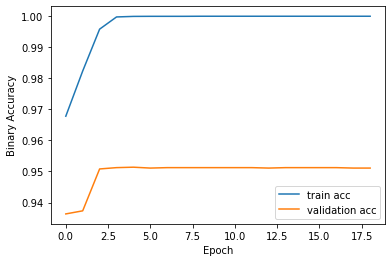

In [27]:
# Accuracy

plt.plot(history.history['binary_accuracy'][1:], label='train acc')
plt.plot(history.history['val_binary_accuracy'][1:], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend(loc='lower right')

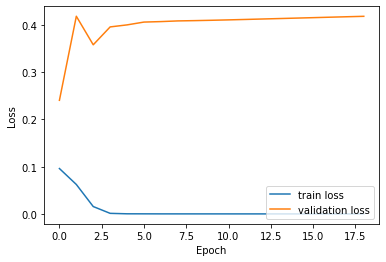

In [28]:
# Loss

plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

For `visualizing embeddings` we can use [Tensorflow Projector](https://projector.tensorflow.org/) and projector look like below image. ![](https://www.tensorflow.org/tensorboard/images/embedding_projector.png?raw=1)

In [29]:
# Getting weights of our embedding layer
embedding_layer = model.layers[0]
embedding_layer_weigths = embedding_layer.get_weights()[0]
print(embedding_layer_weigths.shape)

# Reversing the `word_index`
reverse_word_index = {value: key for key, value in word_index.items()}

# Writing vectors and their meta data which when entered to Tensorflow Project,
# it will display our Word Embedding
out_vectors = io.open('vecs.tsv', 'w', encoding='utf-8')
out_metadata = io.open('meta.tsv', 'w', encoding='utf-8')
# Skipping over the first word in vocabulary which is '<OOV>' (if set oov_token parameter set then)
for word_num in range(1, vocab_size):
    words = reverse_word_index[word_num]
    embeddings = embedding_layer_weigths[word_num]
    out_metadata.write(words + '\n')
    out_vectors.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_vectors.close()
out_metadata.close()

(15000, 120)


The first value of the above output is the `vocab_size` and second value is the `embedding_dim`. If you are going to work in `Google Colab` then below code will do the job of saving `vectors` and `metadata` easily.

In [30]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')  
    
    print('Downloaded!!!')

## **🔮 Evaluation**

![](https://media.giphy.com/media/3o6MbkuhWMQd4OajSg/giphy.gif)

For `predicting` or `evaluation` always use the `tokenizer` and `hyperparameter` like `turncating_type`, `max_len` and so on which was used while training.

In [31]:
tokenizer.fit_on_texts(x_test.headline.tolist())

In [32]:
x_test_sequences = tokenizer.texts_to_sequences(x_test.headline.tolist())
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)

y_test_list = np.array(y_test.is_sarcastic.tolist())

In [33]:
# evaluating on testing data
_, binary_acc, auc_roc, precision, recall = model.evaluate(x_test_padded, y_test_list)
test_metrics_info = {
    'binary_accuracy': round(binary_acc, 4),
    'auc_roc': round(auc_roc, 4),
    'precision': round(precision, 4),
    'recall': round(recall, 4),
    'f1_score': round((2 * (precision * recall)) / (precision + recall), 4)
}

print(json.dumps(test_metrics_info, indent=2))

260/260 [==============================] - 1s 3ms/step - loss: 3.7269 - binary_accuracy: 0.6295 - auc_roc: 0.6563 - precision: 0.5981 - recall: 0.5886
{
  "binary_accuracy": 0.6295,
  "auc_roc": 0.6563,
  "precision": 0.5981,
  "recall": 0.5886,
  "f1_score": 0.5933
}


In [34]:
# predictions
predictions = model.predict_classes(x_test_padded)
for i in range(10):
    print(f'# {i+1} Headline: {x_test.iloc[i].values[0]}')
    print(f'Prediction: {predictions[i]}')
    print(f'Actual: { y_test.iloc[i].values[0]}')
    print()

# 1 Headline: these simple facebook shortcuts will save you time
Prediction: [0]
Actual: 0

# 2 Headline: local burger feels especially disgusting today
Prediction: [1]
Actual: 1

# 3 Headline: nobody keeps baby from the corner
Prediction: [1]
Actual: 0

# 4 Headline: sick of light pollution head to national park study says.
Prediction: [1]
Actual: 0

# 5 Headline: the truth about water as hangover prevention
Prediction: [0]
Actual: 0

# 6 Headline: gabrielle union on the #metoo movthement the floodgates have opened for white women
Prediction: [0]
Actual: 0

# 7 Headline: the best fictional holidays from television
Prediction: [0]
Actual: 0

# 8 Headline: more latinos seek citizenship to vote against trump
Prediction: [0]
Actual: 0

# 9 Headline: coloradofs new revenge porn statute is good law and sound policy
Prediction: [0]
Actual: 0

# 10 Headline: not sure what an apple watch is for try these 12 apps
Prediction: [0]
Actual: 0



In [35]:
# Testing on unseen data

sentences = [
    'The whether today is bright and sunny.',
    'Not all men are annoying. Some are dead.',
    'yellowstone park attempts to increase ranger population with new mating program',
    'If you’re going to tell people the truth, be funny or they’ll kill you.',
    'He who laughs last didn’t get the joke'
]

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)

predictions = model.predict_classes(padded)
print(predictions)

[[0]
 [0]
 [1]
 [0]
 [0]]


## 🎁 Saving the model

In [36]:
model.save('model')

---

If this kernel helped you then don't forget to 👍 `like` and share your 🎙 `feedback`.

![](https://media.giphy.com/media/Yc8Vb9KRvExa/giphy.gif)

And this is how a `recursion` works.

---